# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

![alt text](https://drive.google.com/uc?id=1GAWfaucw0yYWOvVFHCvPUAIe87sqRxAd)

![alt text](https://drive.google.com/uc?id=1zT5SjHQaN0LxV-aSXQuqHFlnTh4iHQmu)

![alt text](https://drive.google.com/uc?id=1e0ZdhUZ-uHYcER1QlgXECT8QqKS7Zq7W)

- Data source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation
- Clickable link for the full list of startups in AI medical imagery: https://research.aimultiple.com/looking-for-better-medical-imaging-for-early-diagnostic-and-monitoring-contact-the-leading-vendors-here/

![alt text](https://drive.google.com/uc?id=1l_L8fKJTubEuHl1hvsQgUHLQIW7ha8ua)

![alt text](https://drive.google.com/uc?id=1VzbRzkgsUCLB2gQab5324f6Wy756KtoU)

![alt text](https://drive.google.com/uc?id=1O0LFxybEkdp2wTPJN8PpPHtlJWB9Z0fn)

# TASK #2: IMPORT LIBRARIES AND DATASETS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from PIL import Image
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [3]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/My Drive/Colab Notebooks/Projects/Healthcare AI

/content/drive/My Drive/Colab Notebooks/Projects/Healthcare AI


In [5]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data/data_mask.csv')

![alt text](https://drive.google.com/uc?id=1Surtfp9XVt-anBuK6g5g7IeU1yirVH_1)

In [6]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [7]:
brain_df.head(10)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
5,TCGA_CS_5395_19981004,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0
6,TCGA_CS_5395_19981004,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
7,TCGA_CS_5395_19981004,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...,0
8,TCGA_CS_5395_19981004,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...,0
9,TCGA_CS_5395_19981004,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...,0


In [8]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [9]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

MINI CHALLENGE #1:
  - Do we have a balanced dataset? 
  - How many samples are classified as 'healthy'?

In [10]:
# Obtain the number of images with mask
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# TASK #3: PERFORM DATA VISUALIZATION

In [11]:
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
...,...,...,...,...
3924,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,0
3925,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,0
3926,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,0
3927,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,0


In [12]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [13]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [14]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [15]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

In [16]:
type(brain_df.mask_path[623])

str

In [17]:
brain_df.mask_path[623]

'TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_6_mask.tif'

In [18]:
image_dir = 'Brain_MRI/'

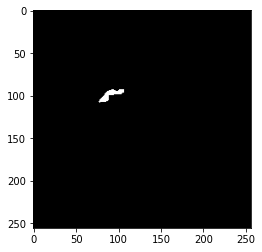

In [19]:
plt.imshow(cv2.imread(image_dir+brain_df.mask_path[623]))

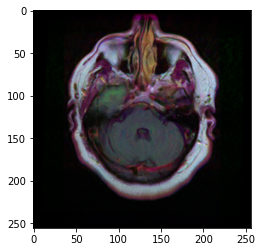

In [20]:
plt.imshow(cv2.imread(image_dir+brain_df.image_path[623]))

In [21]:
cv2.imread(image_dir+brain_df.mask_path[623]).max()

255

In [22]:
cv2.imread(image_dir+brain_df.mask_path[623]).min()

0

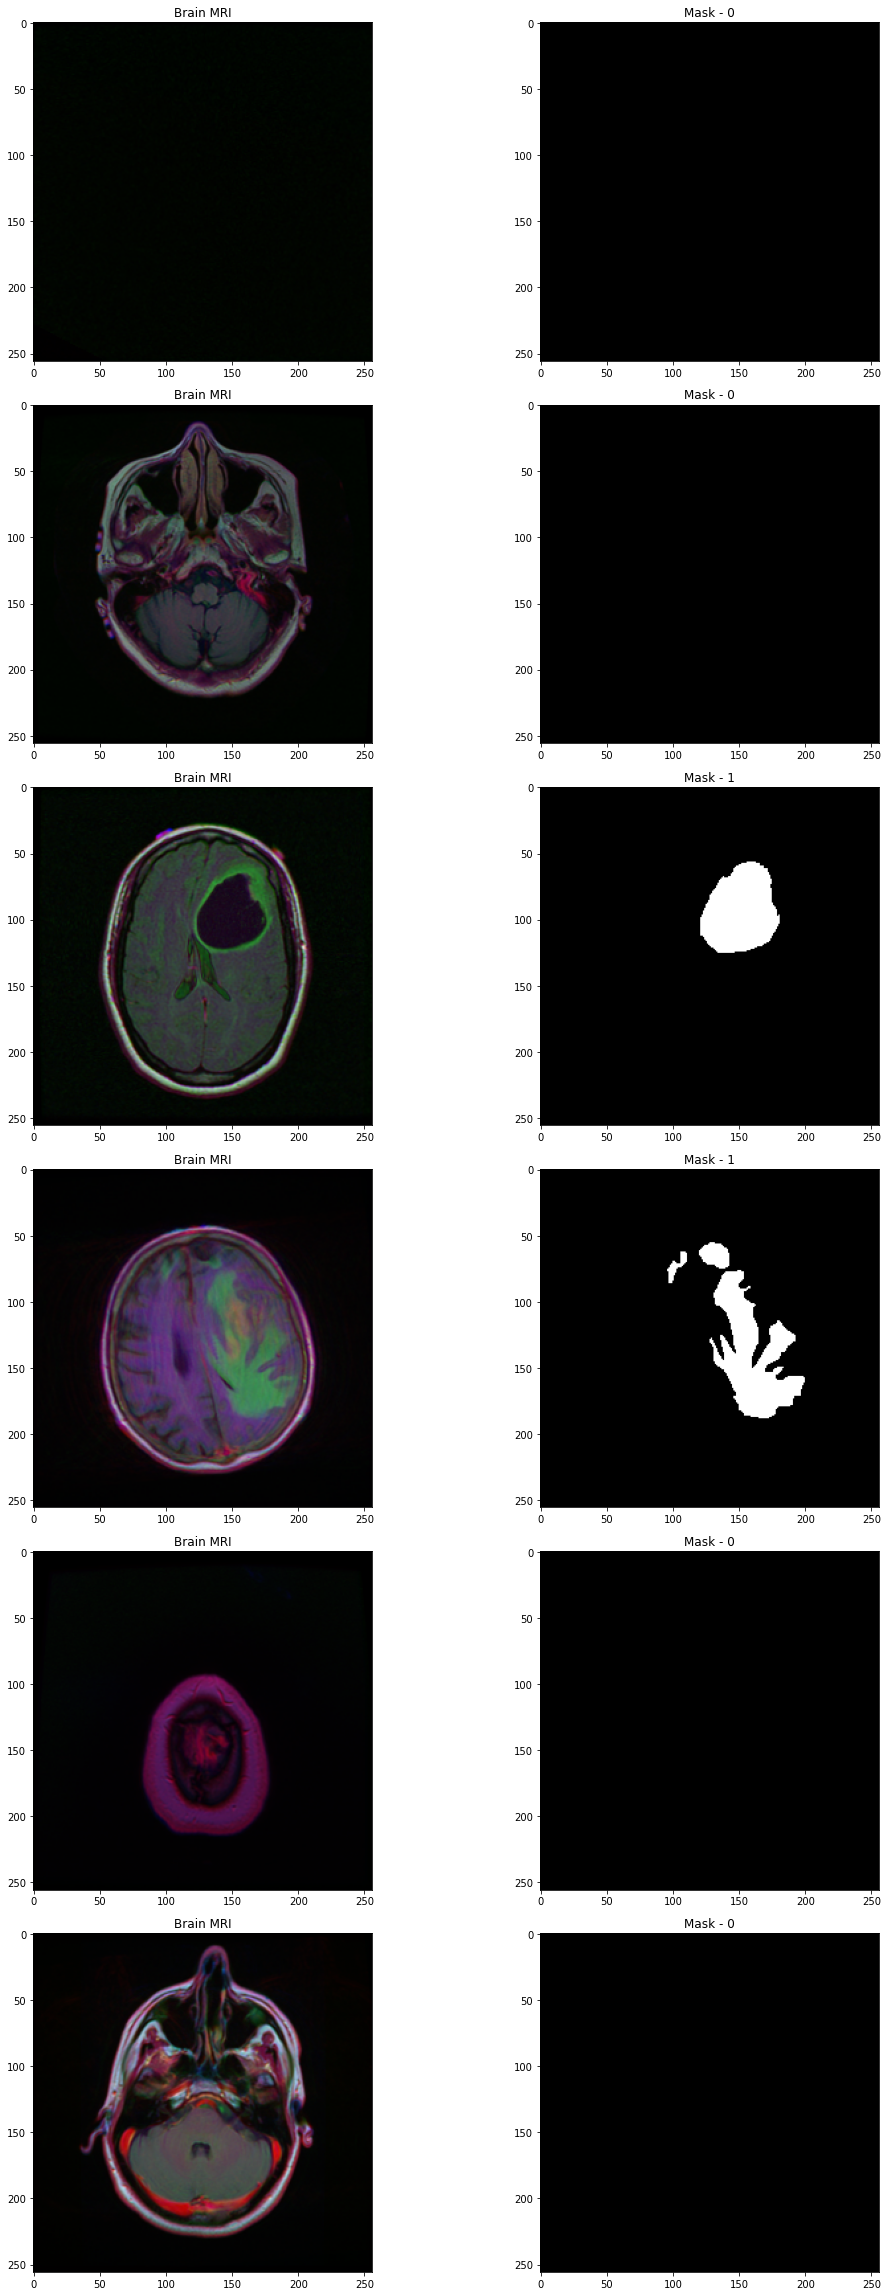

In [23]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(image_dir+brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(image_dir+brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

MINI CHALLENGE #2: 
 - Plot 12 randomly selected (1) MRI scan images from only sick patients followed by (2) corresponding mask, (3) both MRI image and the corresponding mask (in red color) on top of each other

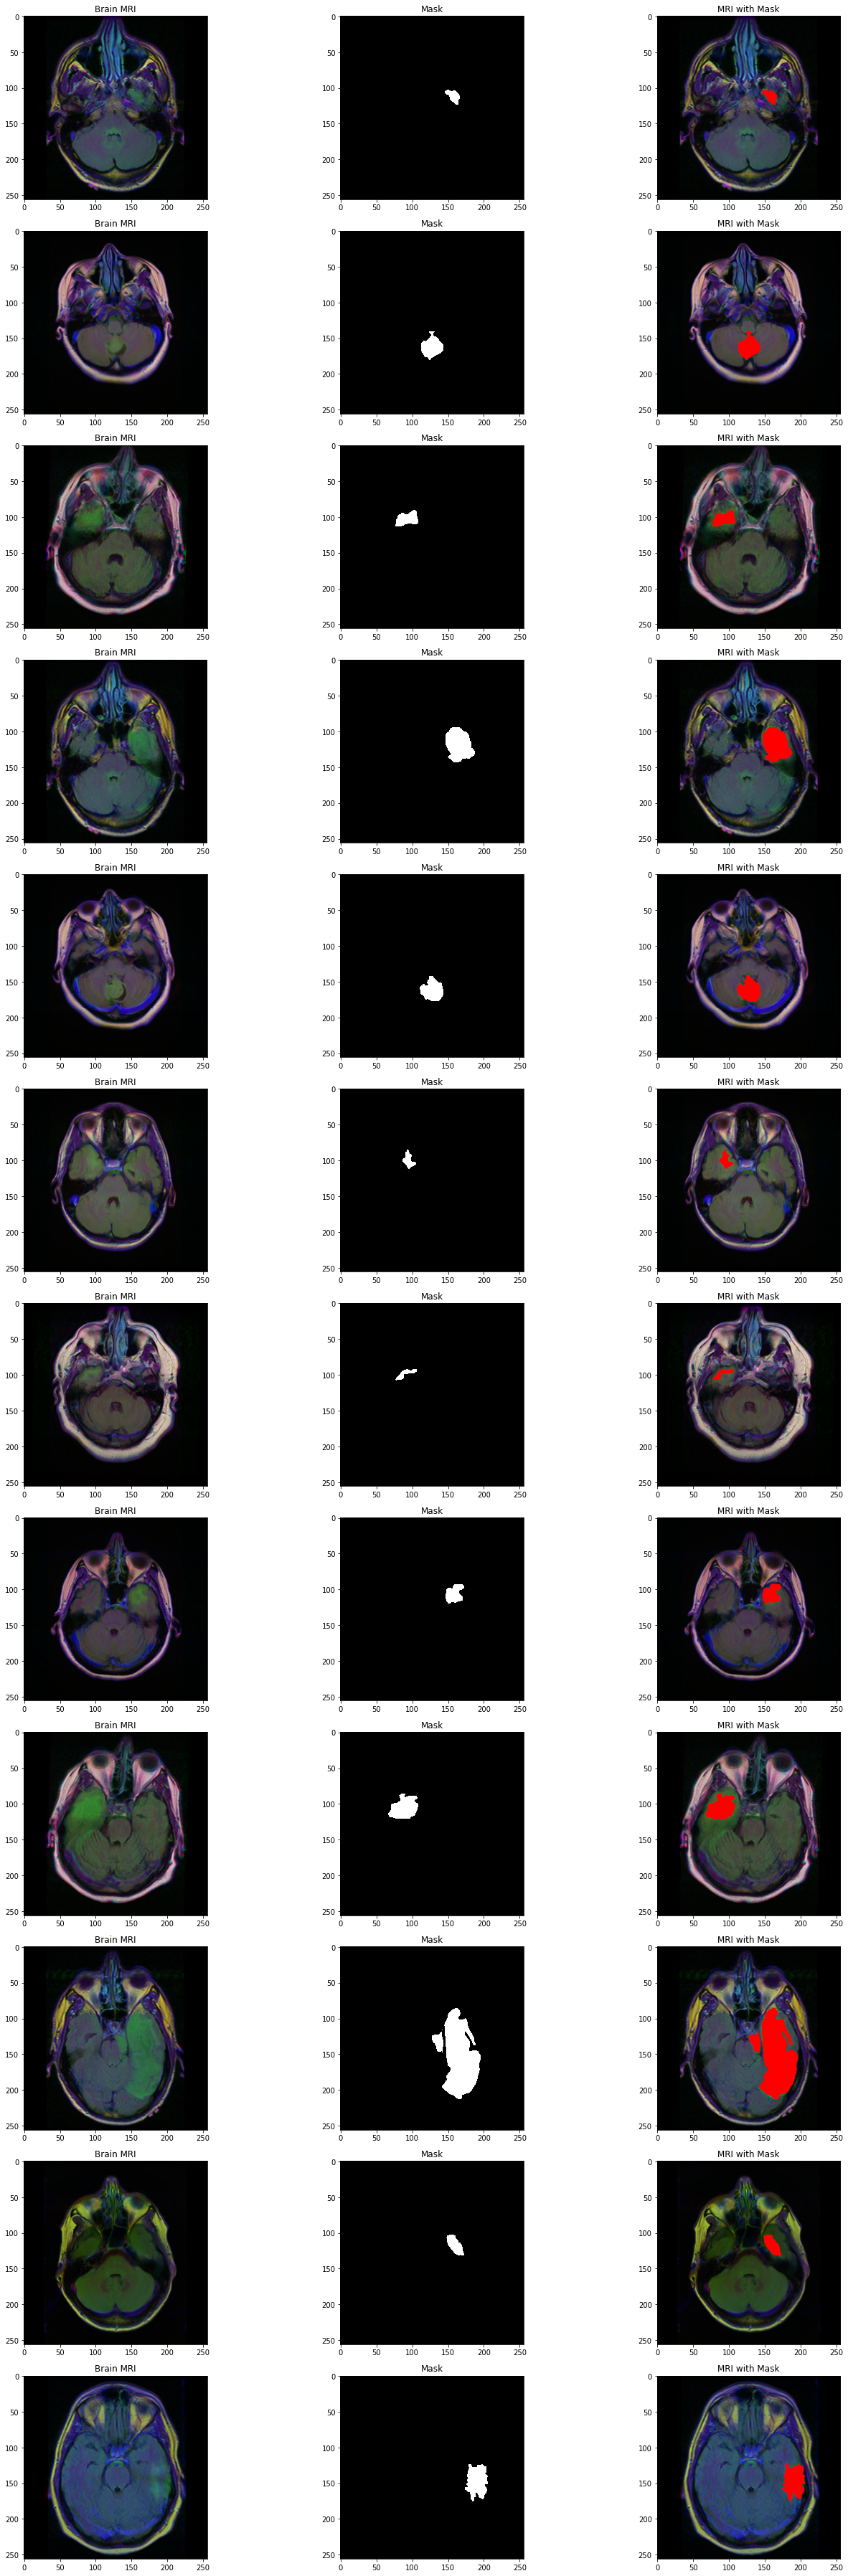

In [24]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(image_dir+brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(image_dir+brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


# TASK #4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS AND RESNETS 

![alt text](https://drive.google.com/uc?id=1t8U50NpbLYLFgrZaEQJlp-_GFJ_iMudZ)

- Feature Extraction and Convolutions: https://setosa.io/ev/image-kernels/
- CNN Visualization: https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html


![alt text](https://drive.google.com/uc?id=14oxDfaeHVlNuzUQDRtAOpbtYYlQ9esuL)

- Link to ResNet paper entitled (Deep Residual Learning for Image Recognition): https://arxiv.org/pdf/1512.03385.pdf

MINI CHALLENGE #3: 
 - What is the perfomance of ResNet on ImageNet dataset?
 - Explore other CNN architectures such as AlexNet and list their performance compared to ResNet (external research is required)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

![alt text](https://drive.google.com/uc?id=1CjDpQ-awUrYyQoYFWDEXCECCGhqk46RJ)

![alt text](https://drive.google.com/uc?id=1Vv318FHKynd3neKwIFC5PgFCFwhdBt1s)

![alt text](https://drive.google.com/uc?id=17sRAYegWAOKASMmzoVe0mnNMXJDFc5IP)

- Excellent Resource on transfer learning by Dipanjan Sarkar: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
- Article by Jason Brownlee: https://machinelearningmastery.com/transfer-learning-for-deep-learning/

MINI CHALLENGE #4: 
- List the challenges of transfer learning (external research is required)

# TASK #6: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [25]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [26]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [27]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [28]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [29]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.4 MB/s eta 0:00:00


In [30]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [31]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= 'Brain_MRI/',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= 'Brain_MRI/',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= 'Brain_MRI/',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [32]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 1s 0us/step


In [33]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [34]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [35]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [37]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [38]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="data/classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [39]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 50, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/50
177/177 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.7088
Epoch 1: val_loss improved from inf to 0.64732, saving model to data/classifier-resnet-weights.hdf5
177/177 [==============================] - 767s 4s/step - loss: 0.7379 - accuracy: 0.7088 - val_loss: 0.6473 - val_accuracy: 0.6653
Epoch 2/50
177/177 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.7510
Epoch 2: val_loss did not improve from 0.64732
177/177 [==============================] - 38s 216ms/step - loss: 0.5083 - accuracy: 0.7510 - val_loss: 1.1012 - val_accuracy: 0.6633
Epoch 3/50
177/177 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.7733
Epoch 3: val_loss did not improve from 0.64732
177/177 [==============================] - 39s 219ms/step - loss: 0.4808 - accuracy: 0.7733 - val_loss: 11.6833 - val_accuracy: 0.3327
Epoch 4/50
177/177 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.8275
Epoch 4: val_loss did

In [40]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("data/classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

MINI CHALLENGE #5: 
- Change the network architecture by adding more/less dense layers, neurons or dropout. 
- print out the model summary and compare the total number of trainable parameters between the original and new model

# TASK #7: ASSESS TRAINED MODEL PERFORMANCE

In [41]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('data/resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('data/weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [42]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 119s 3s/step


In [43]:
test_predict.shape

(576, 2)

In [44]:
test_predict

array([[1.0000000e+00, 6.0201510e-23],
       [2.9396375e-13, 1.0000000e+00],
       [2.5465421e-11, 1.0000000e+00],
       ...,
       [9.9971396e-01, 2.8598297e-04],
       [1.5708314e-07, 9.9999988e-01],
       [1.0000000e+00, 6.6004030e-15]], dtype=float32)

In [45]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [46]:
predict

array(['0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0',
       '0', '1', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0',
       '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '0', '0', '1',
       '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0',
       '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '1', '1', '1', '1', '0', '1', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0',
       '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0', '1',
       '0', '0', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0',
       '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '0', '1', '0',
       '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0

In [47]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [48]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9947916666666666

<AxesSubplot:>

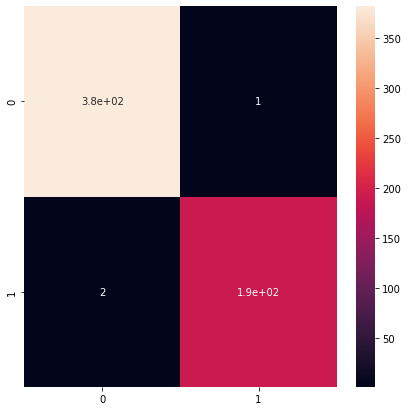

In [49]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

MINI CHALLENGE #6: 
- Print out the classification report and comment on the precision, recall and F1-score results

In [50]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       383
           1       0.99      0.99      0.99       193

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



/usr/local/lib/python3.9/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.9/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.9/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.9/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# TASK #8: UNDERSTAND THE THEORY AND INTUITION BEHIND RESUNET MODELS

![alt text](https://drive.google.com/uc?id=1WOmTUGT_3oN_ltzWlq9ofsw9E1eJwfwH)

![alt text](https://drive.google.com/uc?id=10XpINWmLDApPhIjxq_o8aTbeRjXIQRTD)

![alt text](https://drive.google.com/uc?id=1cVj4egO9bTOMrnkFDn7RhpysF7jjncQT)

![alt text](https://drive.google.com/uc?id=1p4DnLgrWtO8LEoHE1XhPtk00BIuQIJlt)

![alt text](https://drive.google.com/uc?id=1zULGftqTtOQOOY4y0HfkYSZTcHWkEhXT)

# TASK #9: BUILD A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [51]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [52]:
base_dir = 'Brain_MRI/'

In [53]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [54]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [66]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = 'Brain_MRI/', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = self.image_dir + str(list_ids[i])
      
      #mask path
      mask_path = self.image_dir + str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

In [67]:
def prediction(test, model, model_seg):
  '''
  Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
  Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
  is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
  segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
  '''

  #directory
  directory = "Brain_MRI/"

  #Creating empty list to store the results
  mask = []
  image_id = []
  has_mask = []

  #iterating through each image in the test data
  for i in test.image_path:

    path = directory + str(i)

    #reading the image
    img = io.imread(path)

    #Normalizing the image
    img = img * 1./255.

    #Reshaping the image
    img = cv2.resize(img,(256,256))

    #Converting the image into array
    img = np.array(img, dtype = np.float64)
    
    #reshaping the image from 256,256,3 to 1,256,256,3
    img = np.reshape(img, (1,256,256,3))

    #making prediction on the image
    is_defect = model.predict(img)

    #if tumour is not present we append the details of the image to the list
    if np.argmax(is_defect) == 0:
      image_id.append(i)
      has_mask.append(0)
      mask.append('No mask')
      continue

    #Read the image
    img = io.imread(path)

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 3))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256,3 to 1,256,256,3
    X[0,] = img

    #make prediction
    predict = model_seg.predict(X)

    #if the sum of predicted values is equal to 0 then there is no tumour
    if predict.round().astype(int).sum() == 0:
        image_id.append(i)
        has_mask.append(0)
        mask.append('No mask')
    else:
    #if the sum of pixel values are more than 0, then there is tumour
        image_id.append(i)
        has_mask.append(1)
        mask.append(predict)


  return image_id, mask, has_mask

In [77]:

'''
We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}
'''
def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [69]:
# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [70]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [71]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [72]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


MINI CHALLENGE #7: 
- print out the segmentation model summary and list the total number of trainable parameters 

In [73]:
model_seg.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_26 (BatchN  (None, 256, 256, 16  64         ['conv2d_27[0][0]']              
 ormalization)                  )                                                           

# TASK #10: TRAIN A SEGMENTATION RESUNET MODEL TO LOCALIZE TUMOR

## Loss function:
 
We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [78]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [79]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="model/ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [80]:
history = model_seg.fit(training_generator, epochs = 50, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.8346 - tversky: 0.2130
Epoch 1: val_loss improved from inf to 0.79569, saving model to model/ResUNet-weights.hdf5
72/72 [==============================] - 277s 4s/step - loss: 0.8346 - tversky: 0.2130 - val_loss: 0.7957 - val_tversky: 0.2625
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.5068 - tversky: 0.5929
Epoch 2: val_loss improved from 0.79569 to 0.67340, saving model to model/ResUNet-weights.hdf5
72/72 [==============================] - 17s 239ms/step - loss: 0.5068 - tversky: 0.5929 - val_loss: 0.6734 - val_tversky: 0.4095
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.3901 - tversky: 0.7130
Epoch 3: val_loss improved from 0.67340 to 0.66060, saving model to model/ResUNet-weights.hdf5
72/72 [==============================] - 14s 186ms/step - loss: 0.3901 - tversky: 0.7130 - val_loss: 0.6606 - val_tversky: 0.4230
Epoch 4/50
72/72 [==============================] - 

In [83]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("model/ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

# TASK #11: ASSESS TRAINED SEGMENTATION RESUNET MODEL PERFORMANCE

In [84]:
with open('data/ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('data/weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [85]:
# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 [==============================] - 0s 27ms/step


In [86]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_1.tif,No mask,0
1,TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_12...,"[[[[7.135135e-07], [2.4607289e-06], [4.540325e...",1
2,TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13...,"[[[[7.880757e-07], [2.9643904e-06], [6.8416934...",1
3,TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36...,No mask,0
4,TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_41...,No mask,0
...,...,...,...
585,TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_33...,No mask,0
586,TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_3.tif,No mask,0
587,TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_24...,No mask,0
588,TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_2.tif,No mask,0


In [87]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_1.tif,TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_1_...,0,No mask,0
1,TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_12...,TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_12...,1,"[[[[7.135135e-07], [2.4607289e-06], [4.540325e...",1
2,TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13...,TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13...,1,"[[[[7.880757e-07], [2.9643904e-06], [6.8416934...",1
3,TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36...,TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36...,0,No mask,0
4,TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_41...,TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_41...,0,No mask,0


FileNotFoundError: ignored

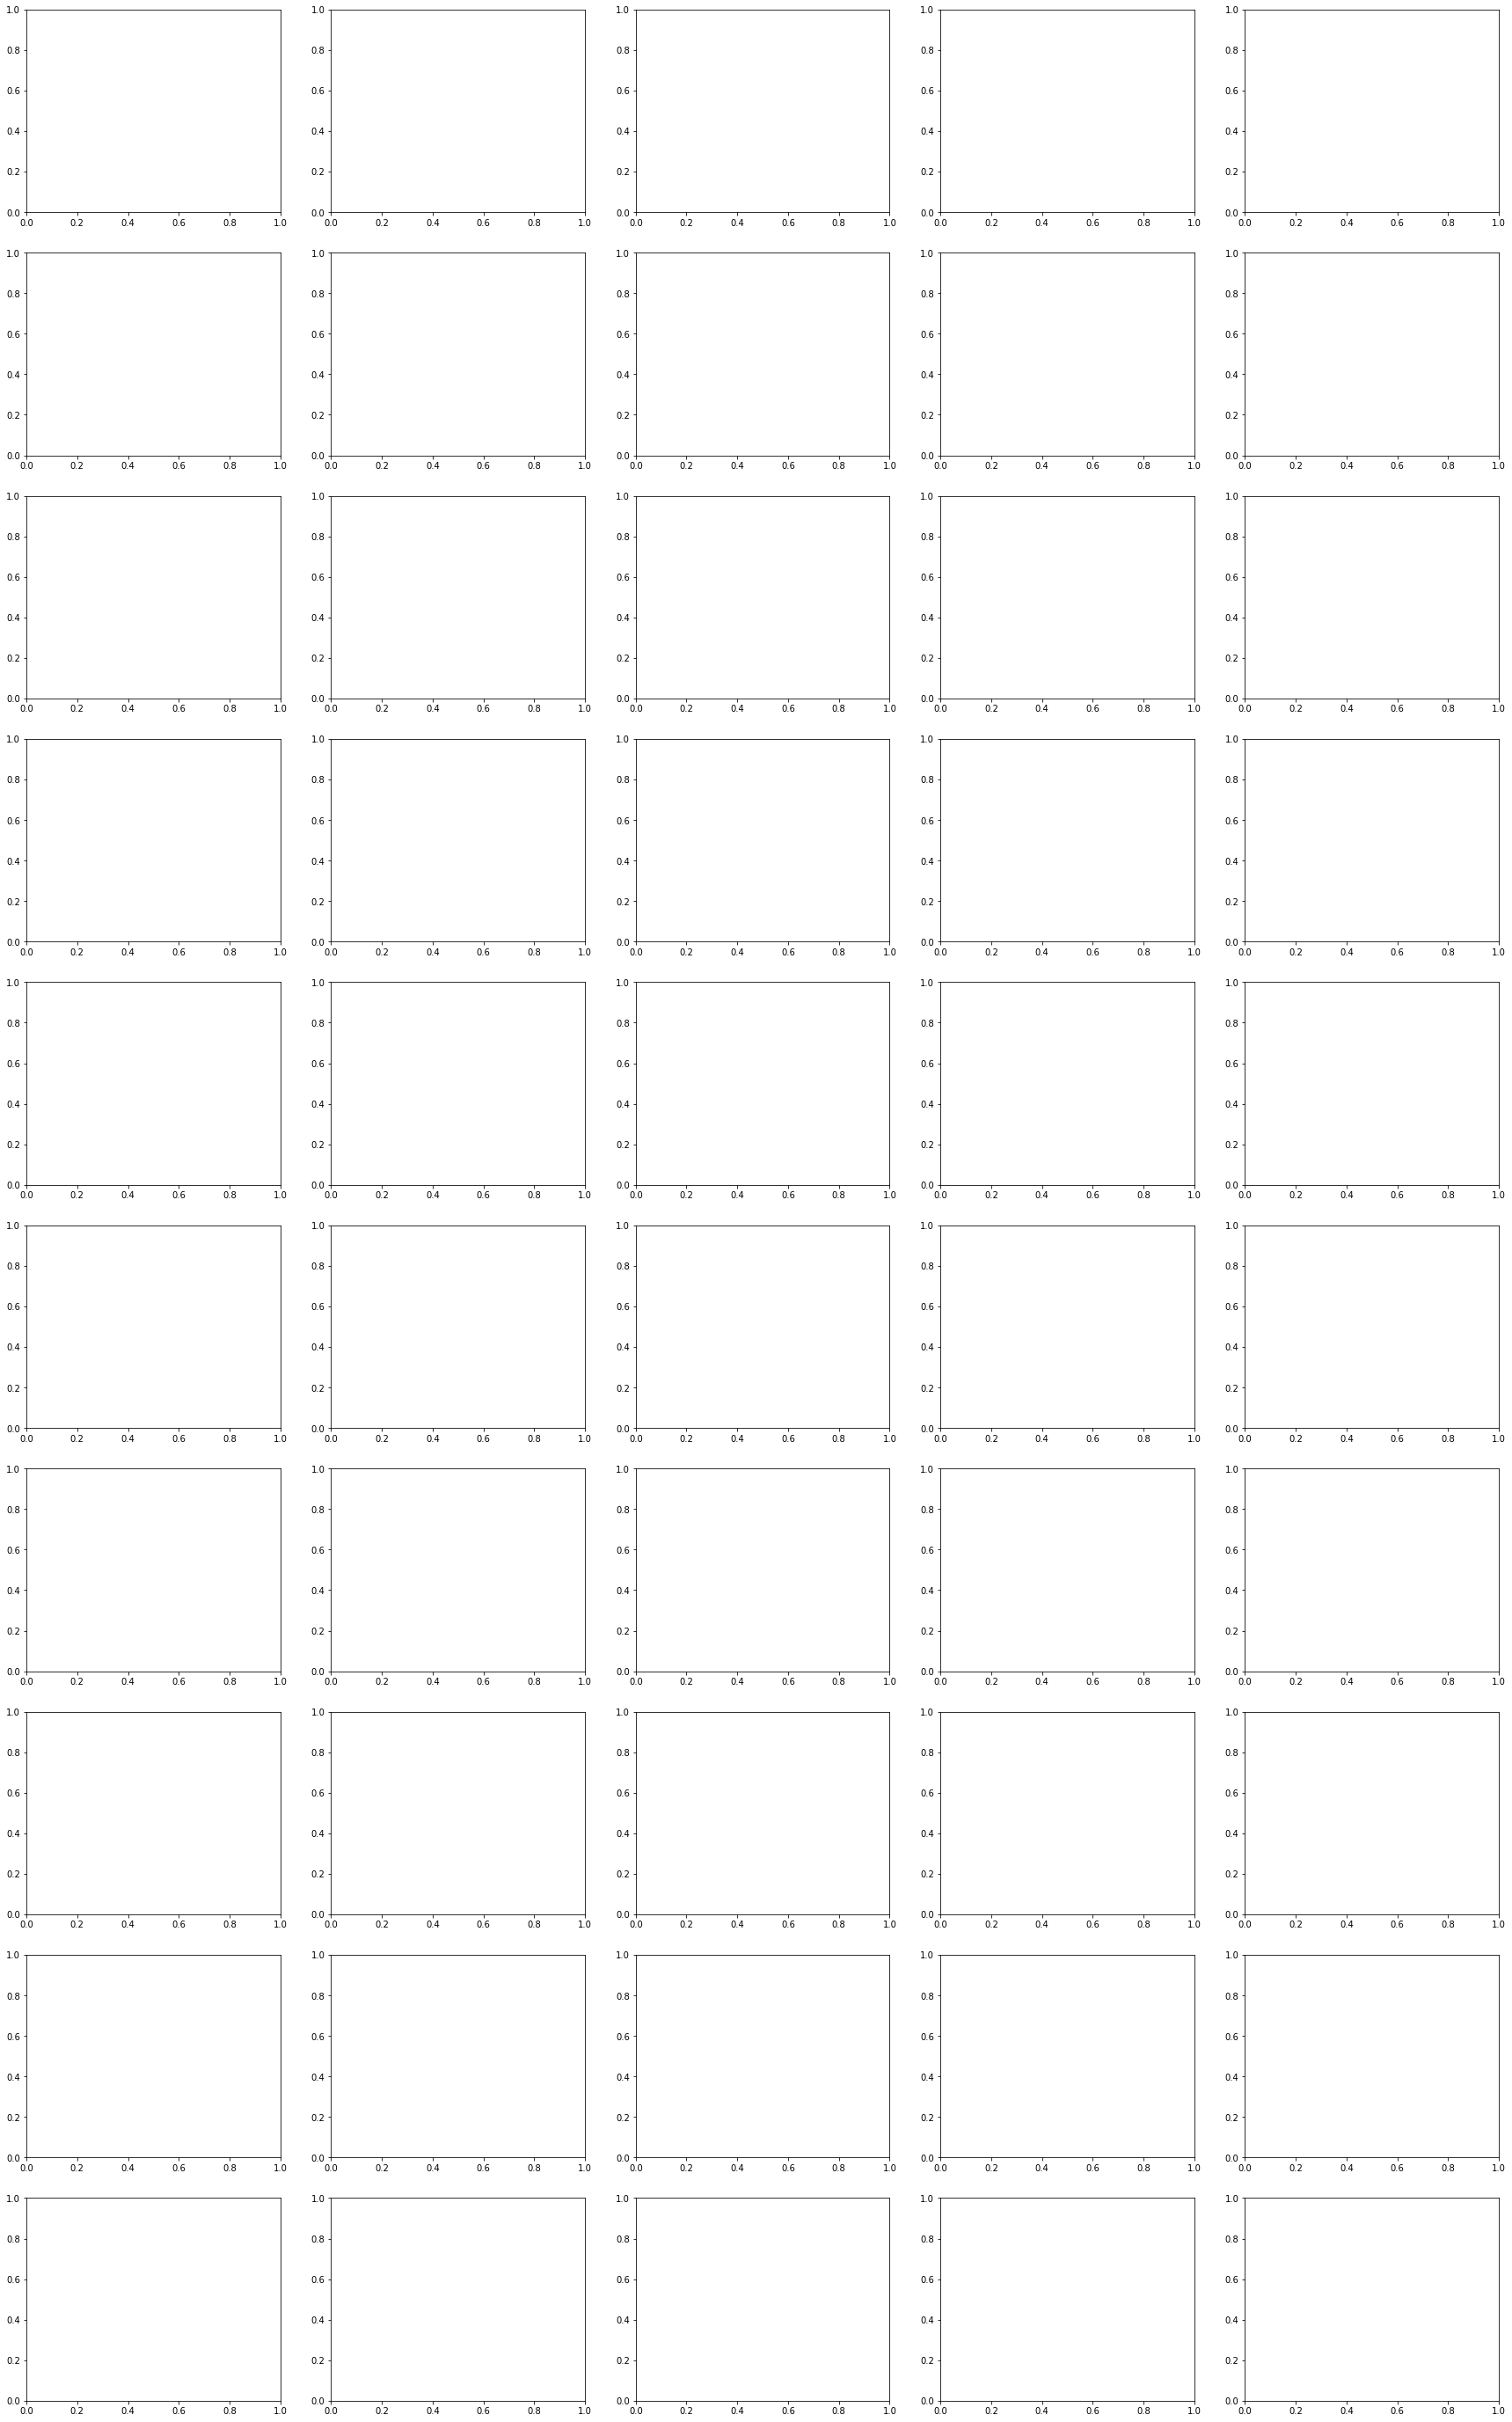

In [88]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

MINI CHALLENGE:
- Plot 30 images along with their corresponding mask
- Visually verify that model predictions made sense 

# EXCELLENT JOB! NOW YOU KNOW HOW TO APPLY AI TO DETECT AND LOCALIZE BRAIN TUMORS. THIS IS A GREAT ACHIEVEMENT IN HEALTHCARE. 

# MINI CHALLENGE SOLUTIONS

MINI CHALLENGE #1

In [ ]:
# Obtain the number of images with mask
brain_df['mask'].value_counts()

MINI CHALLENGE #2

In [ ]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image 
count = 0 
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images 
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image 
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')
    
    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255 
    img[mask == 255] = (255,0,0)    
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

MINI CHALLENGE #3:

- An ensemble of these residual nets achieves 3.57% error
on the ImageNet test set.
- Solution (great article by Siddharth Das): https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

MINI CHALLENGE #4:
- Negative Transfer occurs when transfer learning negatively affect the model. This occurs when the features of old and new tasks are not related.  
- Transfer bounds: Measuring the amount of knowledge transfered is crucial to ensure model quality and robustness. 

MINI CHALLENGE #5:

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# Total parameters (original model) = 25,685,634
# Total parameters (New model with added dense and dropout layers) = 25,751,426

MINI CHALLENGE #6:

In [ ]:

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

MINI CHALLENGE #7:


- Total params: 1,210,513

MINI CHALLENGE #8:

In [ ]:
count = 0 
fig, axs = plt.subplots(30, 5, figsize=(60, 100))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 30: